In [1]:
%load_ext autoreload
% autoreload 2

UsageError: Line magic function `%` not found.


In [2]:
import numpy as np
from matplotlib import pyplot as plt
plt.style.use(['paper.mplstyle'])

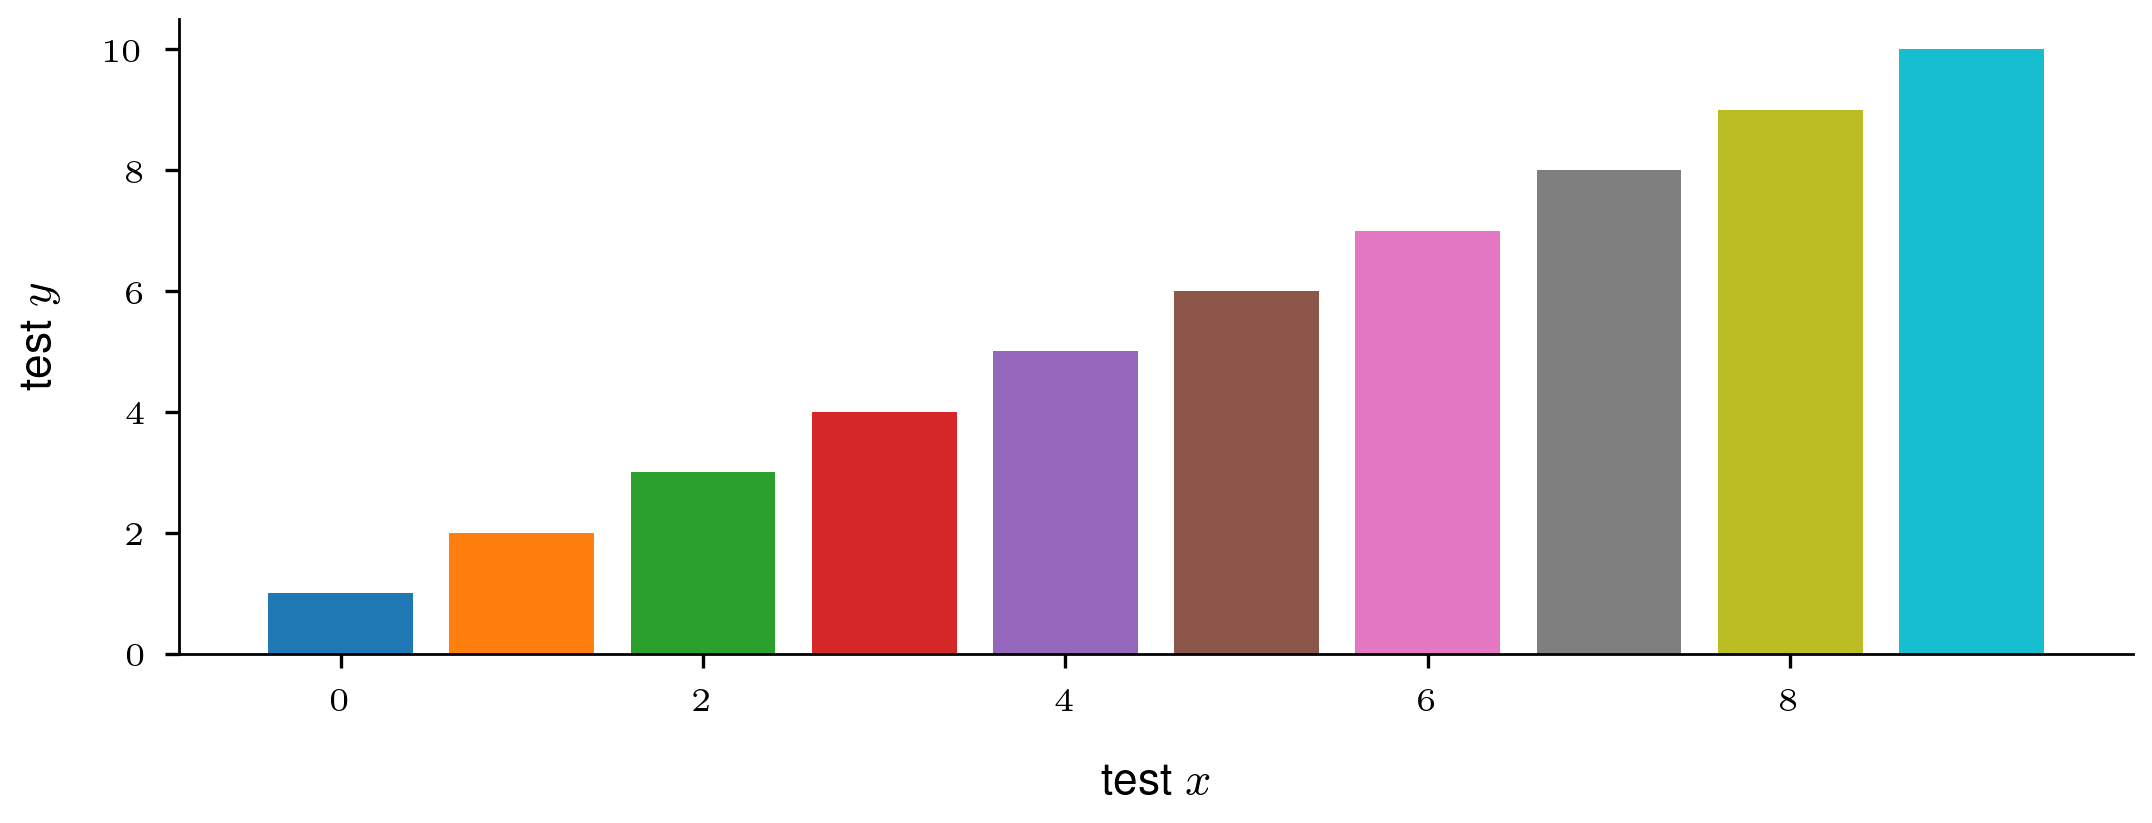

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines

text_width = 6.30107 # in  --> Confirmed with template explanation

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9  # figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family':'sans-serif', 'sans-serif': ['Helvetica']})
matplotlib.rc('text', usetex=True)

plt.figure(dpi=400, figsize=(text_width, text_width/3))
for i in range(10):
       plt.bar(i, i + 1, color=f'C{i}', zorder=2)
       # ^ This zorder nonsense makes the grid  lines go behid the bars. I don't know why this is needed for barplots, but shouldn't usually be needed.
# plt.title('\\textbf{Test}, $\\mathcal{C}, \\mathbb{R}$')
plt.xlabel('test $x$')
plt.ylabel('test $y$')
plt.show()

***FIGURE 2***


In [10]:
seed = 1
dir = f"/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-5/ramping/seed_{seed}_250_2"
targets = np.loadtxt(f'/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_lambda_1E-6/seed_4/targets')
print(dir)

/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-5/ramping/seed_1_250_2


In [11]:
#analyses : computation of the prep idx 
import numpy as np
n_targets = 7
times = [0, 50, 100, 300, 500]


def rates(t, i = 0):
    return np.loadtxt(f'{dir}/rates_{i}_{t}')

def us(t, i = 0):
    return np.loadtxt(f'{dir}/us_{i}_{t}')

def torques(t, i = 0):
    return np.loadtxt(f'{dir}/torques_{i}_{t}')

def mov(t, i = 0):
    return np.loadtxt(f'{dir}/thetas_{i}_{t}')


def prep_idx():
    def get_prep_idx(us, t):
        if t == 0:
            return 0
        else : 
            cutoff = int(t/2 )
            u_prep, u_mov = us[:cutoff], us[cutoff:]
            return np.sum(u_prep**2)/np.sum(u_mov**2)
    def get_all_idces(i):
        ai = np.asarray([get_prep_idx(us(t, i),t) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(8)
    return m, v

def cost_u():
    def cost_u(t, i):
       return np.loadtxt(f'{dir}/u_cost_{i}_{t}')[-1]
    def get_all_idces(i):
        ai = np.asarray([cost_u(t,i) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(8)
    return m, v

def cost_tgt():
    def cost_tgt(t, i):
       return np.loadtxt(f'{dir}/task_cost_{i}_{t}')[-1]
    def get_all_idces(i):
        ai = np.asarray([cost_tgt(t,i) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(8)
    return m, v

def cost_torques():
    def cost_torques(t, i):
       return np.loadtxt(f'{dir}/task_cost_{i}_{t}')[0]
    def get_all_idces(i):
        ai = np.asarray([cost_torques(t,i) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(8)
    return m, v

def mv_loss():
    def cost_torques(t, i):
       return np.loadtxt(f'{dir}/loss_{i}_{t}').sum()
    def get_all_idces(i):
        ai = np.asarray([cost_torques(t,i) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(8)
    return m, v

def reaction_time():
    def get_mov_time(mov, t):
        vel = np.sqrt(mov[:,2]**2 + mov[:,3]**2)
        threshold = 0.1* np.max(vel)
        idces = np.argwhere(vel > threshold)
        min_idx = np.min(idces)
        return min_idx * 0.002 - t*0.001
    def get_all_idces(i):
        ai = np.asarray([get_mov_time(mov(t, i),t) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v
    
def successful_reach():
    def get_mov_time(mov, tgt):
        end_pos = mov[-100:,:2]
        end_diff = np.linalg.norm(end_pos - tgt[:2], axis=1)
        failures = np.sum(np.where(end_diff> 0.1, 1., 0.))
        print(failures)
        return failures
    def get_all_idces(i):
        tgt = targets[i]
        ai = np.asarray([get_mov_time(mov(t, i), tgt) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v

def proj_prep(i):
    return np.loadtxt(f"{dir}/pca/proj_reach_prep_{i}_300")
m_prep, v_prep = prep_idx()
m_cost_u, v_cost_u = cost_u()
m_cost_torques, v_cost_torques = cost_torques()
m_cost_tgt, v_cost_tgt = cost_tgt()
m_loss, v_loss = mv_loss()
m_reac, v_reac = reaction_time()

sr = successful_reach()
print(sr)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
(array([0., 0., 0., 0., 0.]), array([0., 0., 0., 0., 0.]))


FileNotFoundError: /home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-5/ramping/seed_1_250_2/pca/proj_reach_prep_0_300 not found.

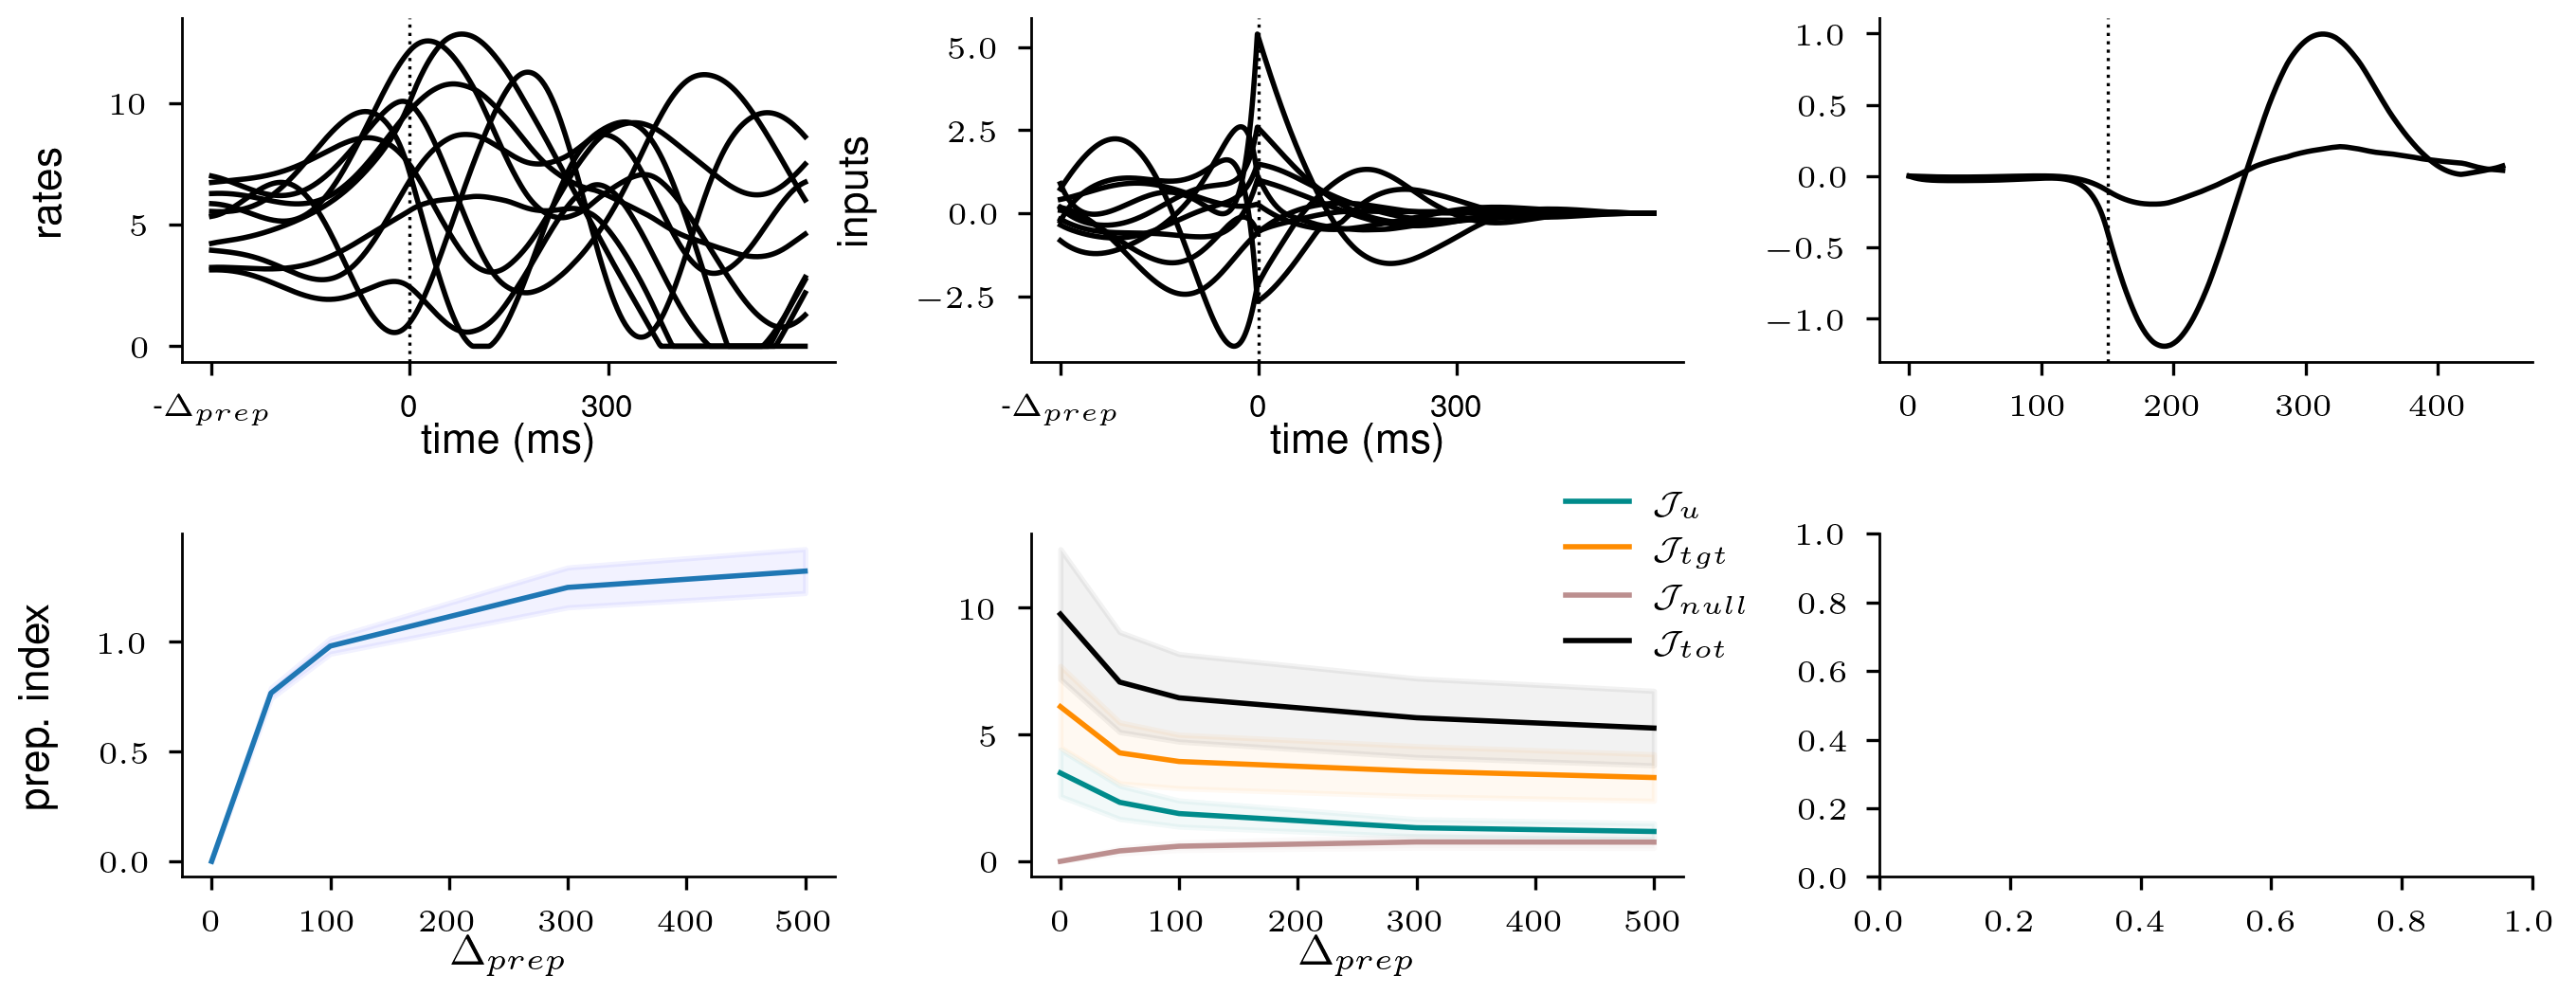

In [12]:
#FIGURE 2
import matplotlib.lines as mlines

fig, axes = plt.subplots(nrows=2, ncols=3,  figsize=(8, 3), dpi = 400)
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.3)

cs = ["darkcyan", "darkorange", 'rosybrown', 'indigo', 'deepskyblue', 'royalblue', 'slategray']
neurons = [0, 8, 11, 20, 44, 100, 101, 144, 198, 199]

#plot the trajectories 
for i, n in enumerate(neurons): 
    axes[0, 0].plot(rates(300)[:,n], 'k')
axes[0,0].set_xlabel('time (ms)', labelpad = -0.5)
axes[0,0].set_ylabel('rates')
axes[0,0].axvline(x = 150,c = 'k', linestyle = 'dotted', linewidth = 0.6)
axes[0,0].set_xticks([0,150,300], ['-$\\Delta_{prep}$', '0', '300'])
#plot the inputs
for i, n in enumerate(neurons): 
    axes[0, 1].plot(us(300)[:,n], 'k')
axes[0,1].set_xlabel('time (ms)', labelpad = -0.5)
axes[0,1].set_ylabel('inputs')
axes[0,1].axvline(x = 150,c = 'k', linestyle = 'dotted', linewidth = 0.6)
axes[0,1].set_xticks([0,150,300], ['-$\\Delta_{prep}$', '0', '300'])

axes[0,2].plot(torques(300)[:,0], 'k')
axes[0,2].plot(torques(300)[:,1], 'k')
# axes[0,2].plot(np.sqrt(mov(300)[:,2]**2 + mov(300)[:,3]**2), 'k')
# axes[0,2].set_xlabel('time (ms)', labelpad = -0.5)
# axes[0,2].set_ylabel('vel')
axes[0,2].axvline(x = 150,c = 'k', linestyle = 'dotted', linewidth = 0.6)
# axes[0,2].set_xticks([0,150,300], ['-$\\Delta_{prep}$', '0', '300'])

mb = m_prep - 1.96*v_prep
mu = m_prep + 1.96*v_prep

axes[1,0].plot(times, m_prep)
axes[1,0].fill_between(times, mb, mu, color='b', alpha=0.05, label='95% confidence')
axes[1,0].set_ylabel('prep. index')
axes[1,0].set_xlabel('$\\Delta_{prep}$', labelpad = -0.5)

mb_u, mu_u = m_cost_u - 1.96*v_cost_u, m_cost_u + 1.96*v_cost_u
mb_tgt, mu_tgt = m_cost_tgt - 1.96*v_cost_tgt, m_cost_tgt + 1.96*v_cost_tgt
mb_torques, mu_torques = m_cost_torques - 1.96*v_cost_torques, m_cost_torques + 1.96*v_cost_torques
mb_loss, mu_loss = m_loss - 1.96*v_loss, m_loss + 1.96*v_loss
axes[1,1].plot(times, m_cost_u, cs[0], label = '$\\mathcal{J}_{u}$')
axes[1,1].fill_between(times, mb_u, mu_u, color=cs[0], alpha=0.05)
axes[1,1].plot(times, m_cost_tgt, cs[1], label =  '$\\mathcal{J}_{tgt}$')
axes[1,1].fill_between(times, mb_tgt, mu_tgt, color=cs[1], alpha=0.05)
axes[1,1].legend(loc = "upper right")
axes[1,1].plot(times, m_cost_torques, cs[2], label =  '$\\mathcal{J}_{null}$')
axes[1,1].fill_between(times, mb_torques, mu_torques, color=cs[2], alpha=0.05)
axes[1,1].plot(times, m_loss, 'k', label =  '$\\mathcal{J}_{tot}$')
axes[1,1].legend(loc = (0.8,0.6))
axes[1,1].fill_between(times, mb_loss, mu_loss, color='k', alpha=0.05)
axes[1,1].set_xlabel('$\\Delta_{prep}$',labelpad = -0.5)

n_prep = 149
for i in range(7):
    axes[1,2].plot(proj_prep(i)[:n_prep,0], proj_prep(i)[:n_prep,1], cs[i])
    if i == 0 or i == 6 : 
        axes[1,2].plot(proj_prep(i)[n_prep,0], proj_prep(i)[n_prep,1], cs[i], marker='<')
    else : 
        axes[1,2].plot(proj_prep(i)[n_prep,0], proj_prep(i)[n_prep,1], cs[i], marker='>')
axes[1,2].set_xlabel('PC1')
axes[1,2].set_ylabel('PC2')
#current_pos = axes[0, 4].get_position()
#axes[0, 4].set_position([current_pos.x0 + 0.03, current_pos.y0, current_pos.width, current_pos.height])

fig.text(0.1, 0.92, '$\\textbf{A}$', size = 16)
fig.text(0.36, 0.92, '$\\textbf{B}$', size = 16)
fig.text(0.66, 0.92, '$\\textbf{C}$', size = 16)
fig.text(0.1, 0.46,'$\\textbf{D}$', size = 16)
fig.text(0.36, 0.46, '$\\textbf{E}$', size = 16)
fig.text(0.66, 0.46, '$\\textbf{F}$', size = 16)
#fig.text(-0.05, 0.17, 'iLQR-MAML', rotation = "vertical", size = 20)
#fig.text(0.4, -0.04, 'time', size = 16, ha='center')
#fig.text(0.94, -0.04, 'output 0', size = 16, ha='center')
plt.show()
#fig.savefig("output_dots.pdf", format = "pdf", bbox_inches='tight')


***Figure 3***

In [ ]:
vprep = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_3/analysis/vprep")
vmov = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_3/analysis/vmov")

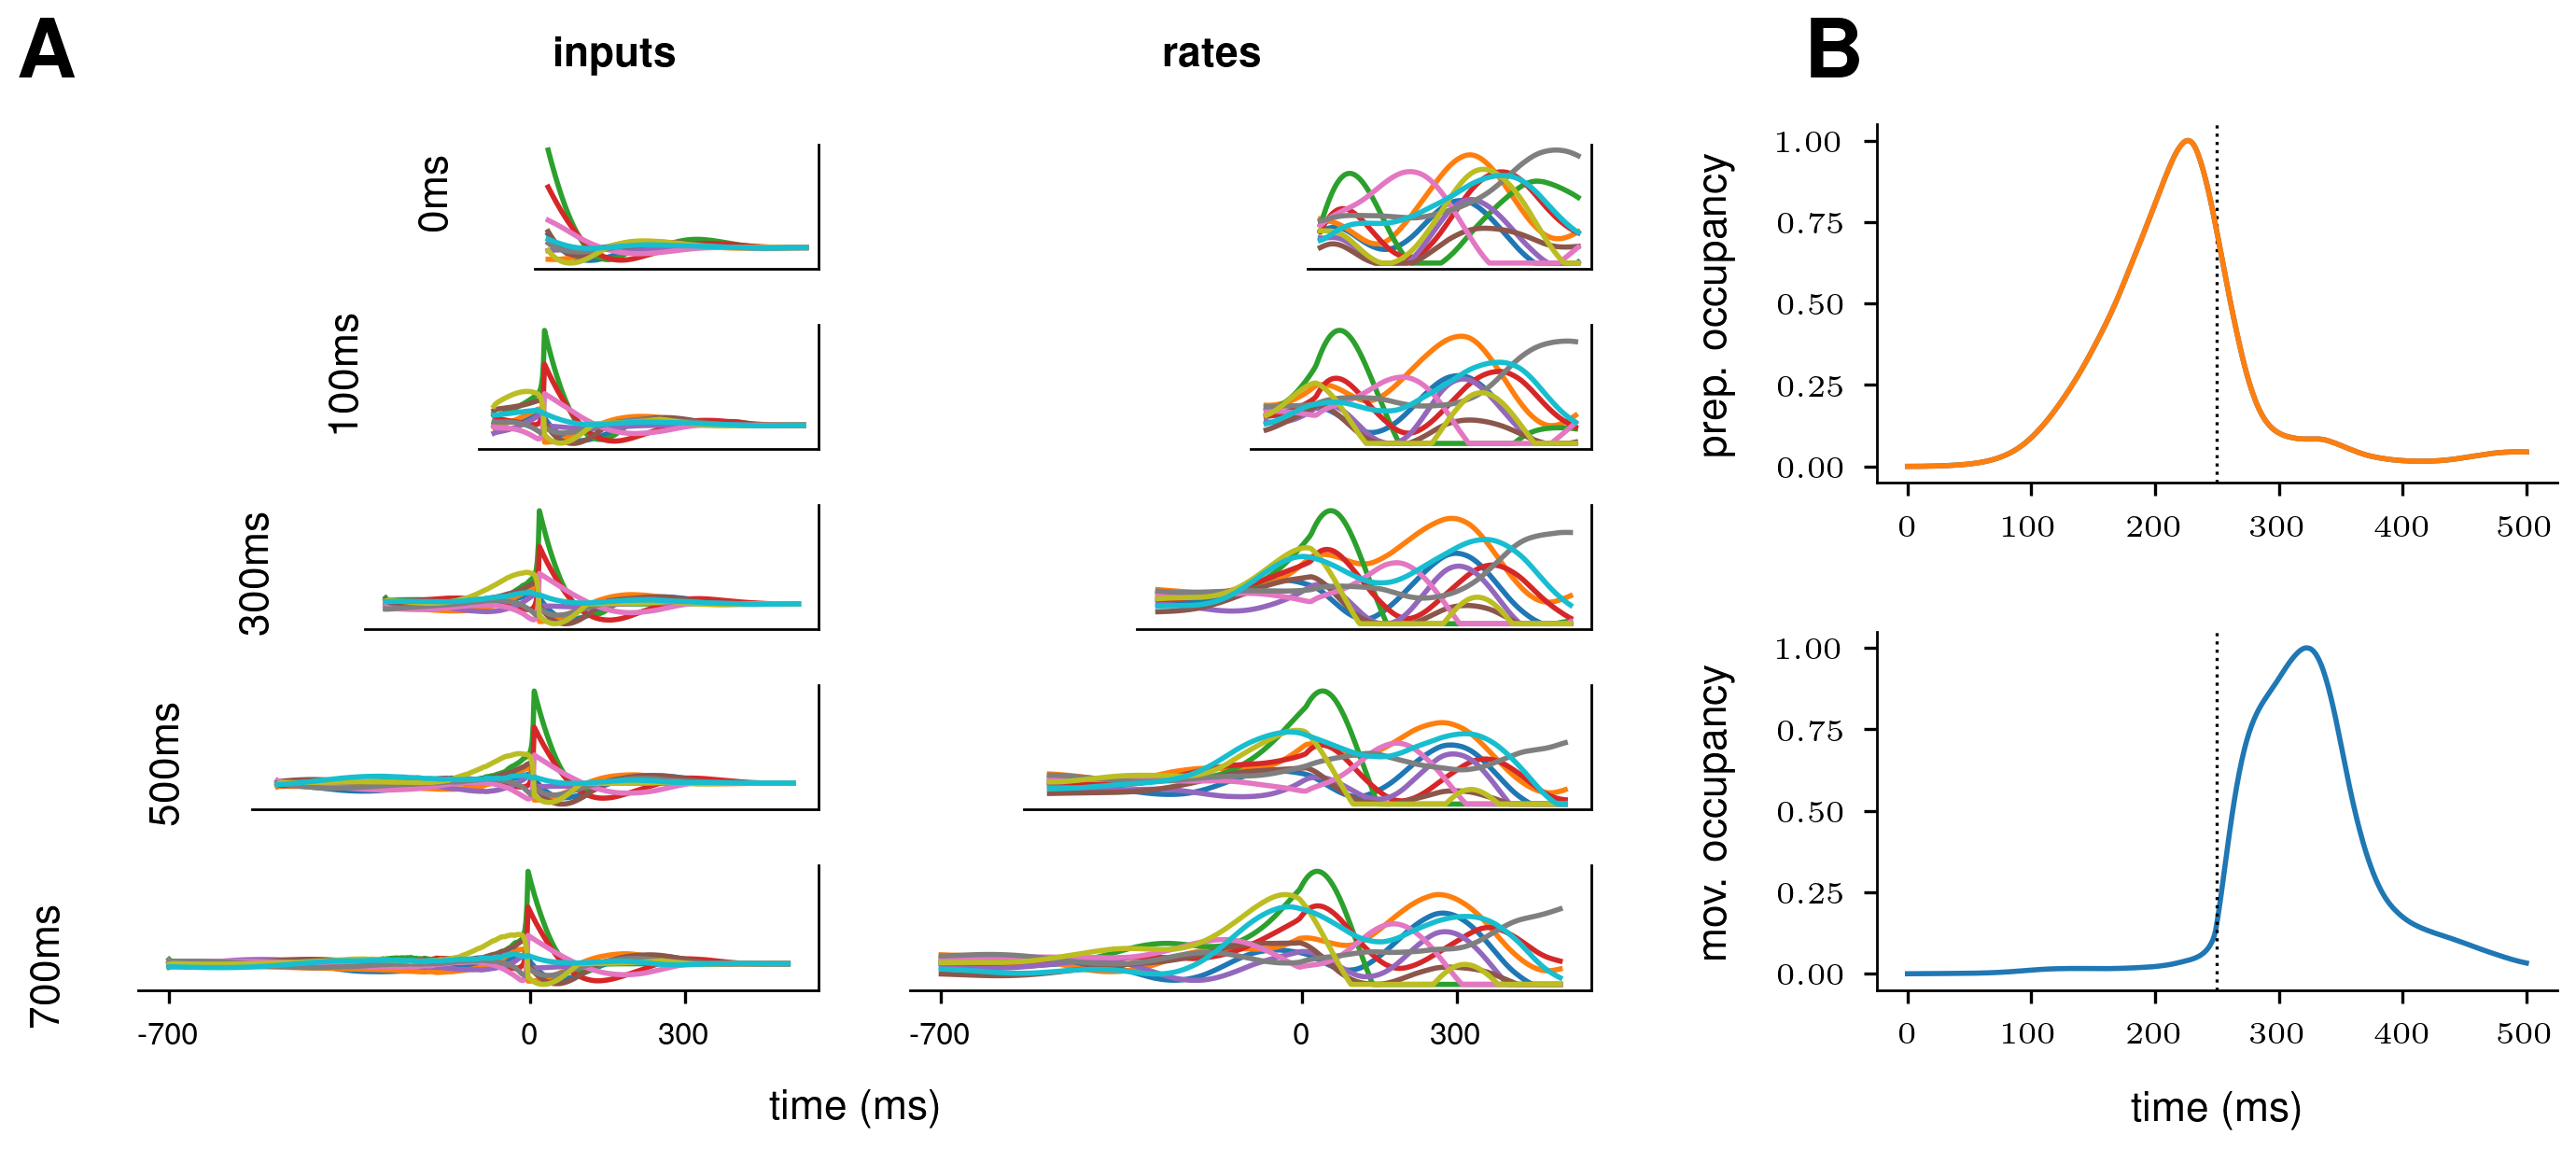

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def realign(ax, frac, offset=0):
    ax.set_yticks([])
    ax.set_xticks([])
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(True)
    current_pos = ax.get_position()
    new_width = frac*current_pos.width
    ax.set_position([current_pos.x0 + offset + current_pos.width - new_width, current_pos.y0, new_width, current_pos.height])

fig = plt.figure(figsize=(8, 3), dpi = 400)
plt.subplots_adjust(hspace=0.45)
gs = gridspec.GridSpec(5, 3)
ax1 = plt.subplot(gs[0, 0])
realign(ax1, frac=5/12, offset = 0.015)
ax1.spines["left"].set_visible(False)
ax1.spines["right"].set_visible(True)
ax2 = plt.subplot(gs[1, 0])
realign(ax2, frac=6/12, offset = 0.015)
ax3 = plt.subplot(gs[2, 0])
realign(ax3, frac=8/12, offset = 0.015)
ax4 = plt.subplot(gs[3, 0])
realign(ax4, frac=10/12, offset = 0.015)
ax5 = plt.subplot(gs[4, 0])
realign(ax5, frac=1, offset = 0.015)
ax5.set_xticks([0,350,500], ['-700', '0', '300'])
#ax6 = plt.subplot(gs[5, 0])
ax7 = plt.subplot(gs[0, 1])
realign(ax7, frac=5/12)
ax8 = plt.subplot(gs[1, 1])
realign(ax8, frac=6/12)
ax9 = plt.subplot(gs[2, 1])
realign(ax9, frac=8/12)
ax10 = plt.subplot(gs[3, 1])
realign(ax10, frac=10/12)
ax11 = plt.subplot(gs[4, 1])
realign(ax11, frac=1)
ax11.set_xticks([0,350,500], ['-700', '0', '300'])
#ax12 = plt.subplot(gs[5, 1])
ax13 = plt.subplot(gs[:2, 2])
ax14 = plt.subplot(gs[2:, 2])

###############################
ax1.plot(us(0)[:,:10])
ax2.plot(us(100)[:,:10])
ax3.plot(us(300)[:,:10])
ax4.plot(us(500)[:,:10])
ax5.plot(us(700)[:,:10])
ax7.plot(rates(0)[:,:10])
ax8.plot(rates(100)[:,:10])
ax9.plot(rates(300)[:,:10])
ax10.plot(rates(500)[:,:10])
ax11.plot(rates(700)[:,:10])
ax13.plot(vprep)
current_pos = ax13.get_position()
ax13.set_position([current_pos.x0 + 0.05, current_pos.y0 - 0.03, current_pos.width, 0.32])
ax13.set_ylabel("prep. occupancy")
ax13.axvline(x = 250,c = 'k', linestyle = 'dotted', linewidth = 0.6)
ax13.plot(vprep)

current_pos = ax14.get_position()
ax14.set_position([current_pos.x0 + 0.05, current_pos.y0, current_pos.width, 0.32])
ax14.plot(vmov)
ax14.axvline(x = 250,c = 'k', linestyle = 'dotted', linewidth = 0.6)
ax14.set_ylabel("mov. occupancy")
ax14.set_xlabel("time (ms)")

fig.text(0.38, 0.01, 'time (ms)', size = fs, ha='center')
fig.text(0.3, 0.95, '\\textbf{inputs}', size = fs, ha='center')
fig.text(0.5, 0.95, '\\textbf{rates}', size = fs, ha='center')
fig.text(0.24, 0.81, '0ms', ha='center', rotation = "vertical")
fig.text(0.21, 0.63, '100ms', ha='center', rotation = "vertical")
fig.text(0.18, 0.45, '300ms', ha='center', rotation = "vertical")
fig.text(0.15, 0.28, '500ms', ha='center', rotation = "vertical")
fig.text(0.11, 0.1, '700ms', ha='center', rotation = "vertical")
fig.text(0.1, 0.94, '$\\textbf{A}$', size = 16)
fig.text(0.7, 0.94, '$\\textbf{B}$', size = 16)
plt.show()
fig.savefig("fig_3.pdf", format = "pdf", bbox_inches='tight')

## Occupancies plot

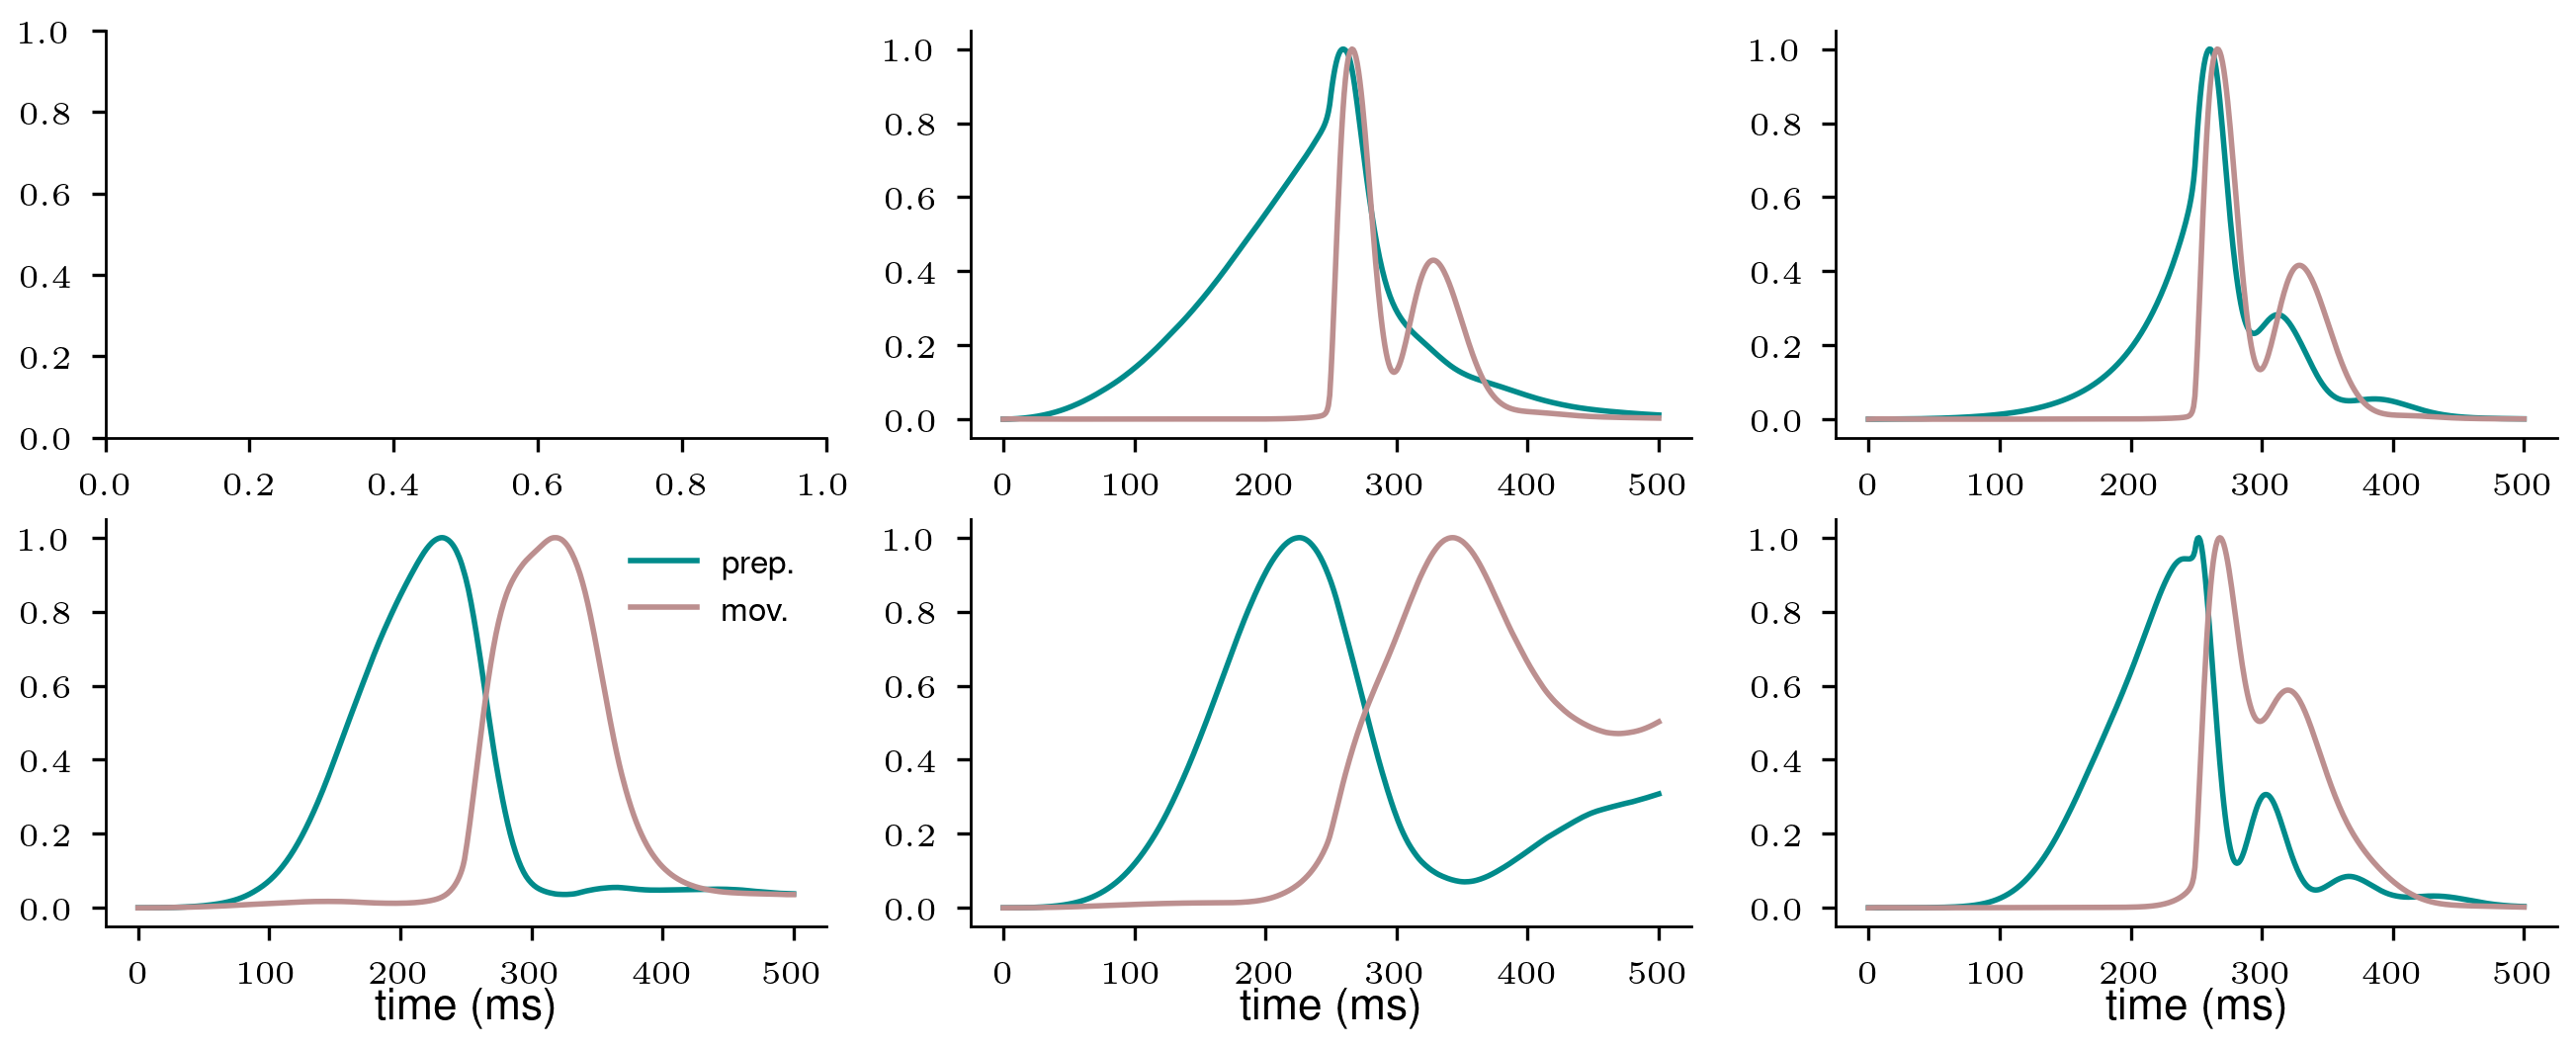

In [ ]:
vprep_soc = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1/analysis/vprep")
vmov_soc = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1/analysis/vmov")
vprep_skew_2 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping_skew/rad_2./analysis/vprep")
vmov_skew_2 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping_skew/rad_2./analysis/vmov")
vprep_rdn_2 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping_rdn/rad_2./analysis/vprep")
vmov_rdn_2 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping_rdn/rad_2./analysis/vmov")
vprep_skew_05 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping_skew/rad_0.5/analysis/vprep")
vmov_skew_05 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping_skew/rad_0.5/analysis/vmov")
vprep_rdn_05 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping_rdn/rad_0.5/analysis/vprep")
vmov_rdn_05 = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping_rdn/rad_0.5/analysis/vmov")

fig, axes = plt.subplots(nrows=2, ncols=3,  figsize=(8, 3), dpi = 400)

cs = ["darkcyan", 'rosybrown', "darkorange",  'indigo', 'deepskyblue', 'royalblue']
neurons = [0, 8, 11, 20, 44, 100, 101, 144, 198, 199]

#plot the trajectories 
axes[1,0].set_xlabel('time (ms)', labelpad = -0.5)
axes[1,0].plot(vprep_soc, cs[0], label="prep.")
axes[1,0].plot(vmov_soc, cs[1], label="mov.")
axes[1,0].legend()

axes[0,1].plot(vprep_rdn_05, cs[0])
axes[0,1].plot(vmov_rdn_05, cs[1])

axes[1,1].set_xlabel('time (ms)', labelpad = -0.5)
axes[1,1].plot(vprep_rdn_2, cs[0])
axes[1,1].plot(vmov_rdn_2, cs[1])

axes[0,2].plot(vprep_skew_05, cs[0])
axes[0,2].plot(vmov_skew_05, cs[1])

axes[1,2].set_xlabel('time (ms)', labelpad = -0.5)
axes[1,2].plot(vprep_skew_2, cs[0])
axes[1,2].plot(vmov_skew_2, cs[1])

### Illustrative plot of the task + cost 

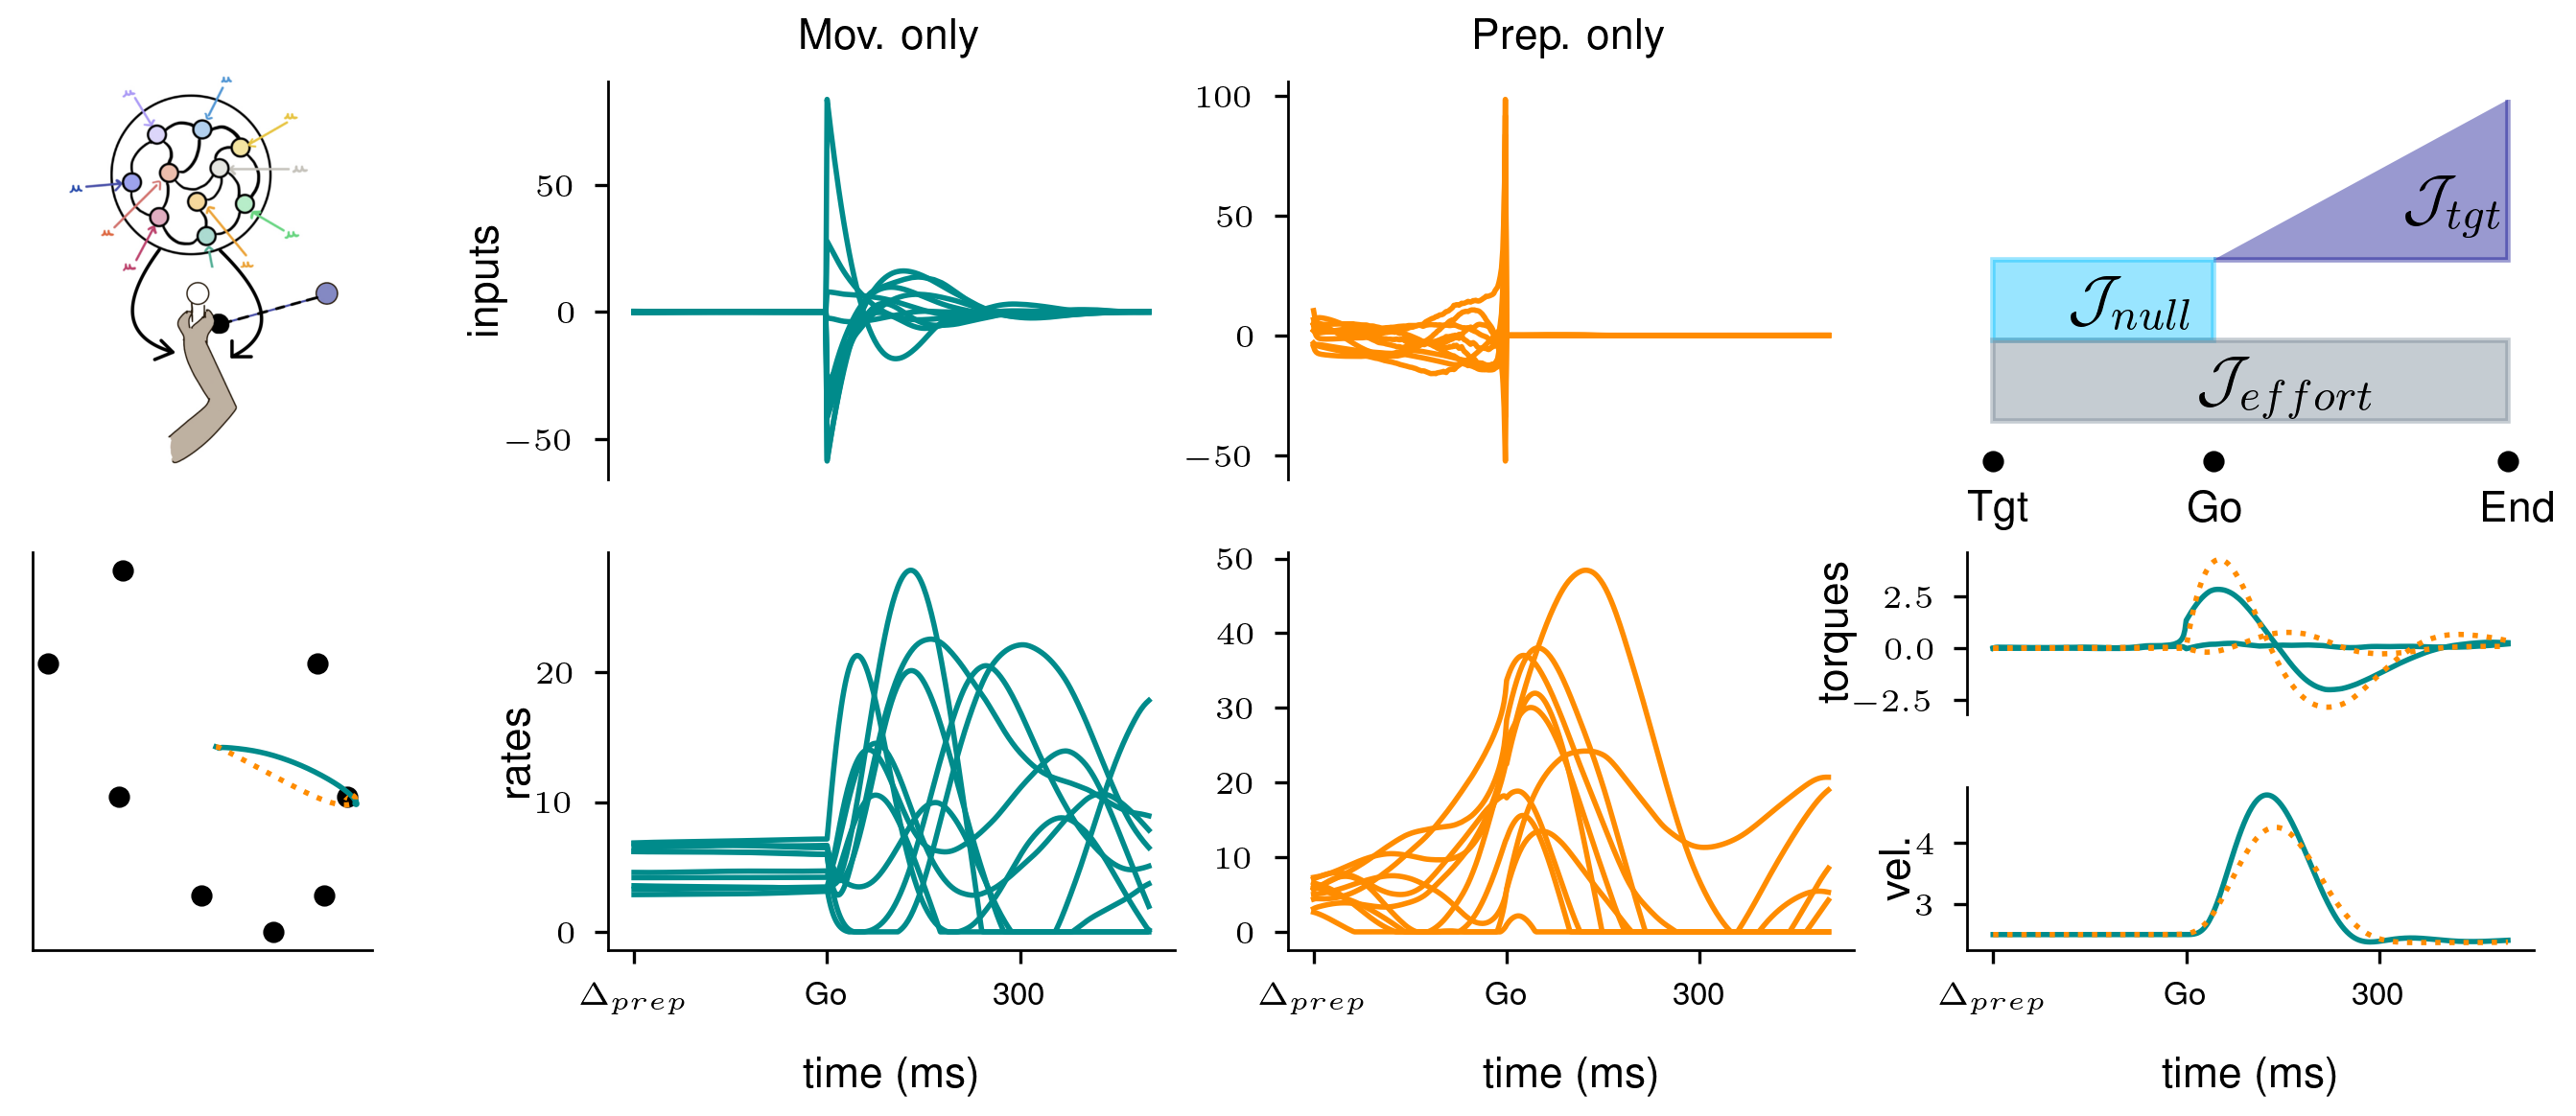

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Polygon, Rectangle

cs = ["darkcyan", "darkorange", 'darkblue', 'deepskyblue', 'slategray']
neurons = [0, 8, 11, 20, 44, 100, 101, 144, 198, 199]


fig = plt.figure(figsize=(8, 3), dpi = 400)
plt.subplots_adjust(hspace=0.45)
plt.subplots_adjust(wspace=1)
gs = gridspec.GridSpec(4, 11)
ax0 = plt.subplot(gs[:2, 0:2])
ax1 = plt.subplot(gs[2:, 0:2])
ax2 = plt.subplot(gs[:2, 2:5])
ax3 = plt.subplot(gs[2:, 2:5])
ax4 = plt.subplot(gs[:2, 5:8])
ax5 = plt.subplot(gs[2:, 5:8])
ax6 = plt.subplot(gs[:2, 8:11])
ax7 = plt.subplot(gs[2, 8:11])
ax8 = plt.subplot(gs[3,8:11])
im = plt.imread('/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/model.jpg') # insert local path of the image.
# fig.delaxes(axes[1,0])
mov_inpts =  np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_0.01_mov/us_4_300")
prep_inpts =  np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_0.01_prep/us_4_300")
mov_activity =  np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_0.01_mov/rates_4_300")
prep_activity = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_0.01_prep/rates_4_300")
prep_thetas = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_0.01_prep/thetas_4_300")
mov_thetas = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_0.01_mov/thetas_4_300")
targets = np.loadtxt(f'/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_lambda_1E-6/seed_4/targets')
torques_prep = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_0.01_prep/torques_4_300")
torques_mov = np.loadtxt("/home/mmcs3/rds/rds-t2-cs133-hh9aMiOkJqI/mmcs3/random_monkeys_random_lambda_1E-6/ramping/seed_1_0.01_mov/torques_4_300")
pos = ax0.get_position()
new_height =  3*pos.height
ax0.set_position([pos.x0 - 0.04, pos.y0 - pos.height, pos.width, new_height])
ax0.imshow(im)
ax0.set_yticks([])
ax0.set_xticks([])
ax0.spines["left"].set_visible(False)
ax0.spines["bottom"].set_visible(False)
ax1.set_yticks([])
ax1.set_xticks([])
pos1 = ax1.get_position()
ax1.set_position([pos.x0 - 0.04, pos1.y0, pos1.width, pos1.height])
ax1.plot(targets[:,0], targets[:,1], 'ko')
ax1.plot(prep_thetas[:,0], prep_thetas[:,1], cs[0])
ax1.plot(mov_thetas[:,0], mov_thetas[:,1], cs[1],ls = "dotted")
ax2.set_xticks([])
ax2.spines["bottom"].set_visible(False)
ax4.set_xticks([])
ax4.spines["bottom"].set_visible(False)
ax3.set_xticks([0,150,300], ['$\\Delta_{prep}$', 'Go', '300'])
ax5.set_xticks([0,150,300], ['$\\Delta_{prep}$', 'Go', '300'])
ax3.set_xlabel("time (ms)")
ax5.set_xlabel("time (ms)")
for i in neurons : 
    ax3.plot(mov_activity[:,i], cs[0])
    ax2.plot(mov_inpts[:,i], cs[0])
    ax5.plot(prep_activity[:,i], cs[1])
    ax4.plot(prep_inpts[:,i], cs[1])
ax2.set_title("Mov. only")
pos6 = ax6.get_position()
ax4.set_title("Prep. only")
ax2.set_ylabel('inputs', labelpad = -0.2)
ax3.set_ylabel('rates', labelpad = -0.2)
pts = np.array([[3/7,0.6], [1,0.6], [1,1]])
p = Polygon(pts, closed=False, alpha = 0.4, color = cs[2])
ax6.add_patch(p)
r1 = Rectangle(xy = (0,0.4), width = 3/7, height = 0.2, color = cs[3], alpha = 0.4)
r2 = Rectangle(xy = (0,0.2), width = 1, height = 0.2, color = cs[4], alpha = 0.4)
ax6.add_patch(r1)
ax6.add_patch(r2)
ax6.text(0.4, 0.25, '$\\mathcal{J}_{effort}$', size = 12)
ax6.text(0.8, 0.7, '$\\mathcal{J}_{tgt}$', size = 12)
ax6.text(0.15, 0.45, '$\\mathcal{J}_{null}$', size = 12)
ax6.set_xticks([])
ax6.set_yticks([])
ax6.spines["bottom"].set_visible(False)
ax6.spines["left"].set_visible(False)
ax6.plot(0,0.1,'ko')
ax6.plot(3/7,0.1,'ko')
ax6.plot(1,0.1,'ko')
ax6.text(-0.05,-0.05,"Tgt")
ax6.text(3/7-0.05,-0.05,"Go")
ax6.text(1-0.05,-0.05,"End")

pos7 = ax7.get_position()
ax7.plot(torques_prep, cs[0])
ax7.plot(torques_mov, cs[1], ls = "dotted")
ax7.set_xticks([])
ax7.set_ylabel('torques', labelpad = -0.5)
ax7.spines["bottom"].set_visible(False)
pos8 = ax8.get_position()
ax8.plot(np.sqrt(mov_thetas[:,1]**2 + mov_thetas[:,2]**2), cs[0])
ax8.plot(np.sqrt(prep_thetas[:,1]**2 + prep_thetas[:,2]**2), cs[1], ls = "dotted")
ax8.set_ylabel('vel.', labelpad = -0.5)
ax8.set_xlabel('time (ms)')
ax8.set_xticks([0,150,300], ['$\\Delta_{prep}$', 'Go', '300'])

